In [1]:
import h5py
import numpy as np


In [32]:
with h5py.File("mytestfile.hdf5", "a") as f:
    dset = f.create_dataset('data_mult', (5,5,5))
    
    
    

In [33]:
with h5py.File('mytestfile.hdf5', 'r') as f:
    print(f.name)
    print(list(f.keys()))
    dset = f['testdata']
    print(dset[()])
    print(f['data_mult'][()])

/
['data_mult', 'test', 'testdata', 'testdata_high']
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


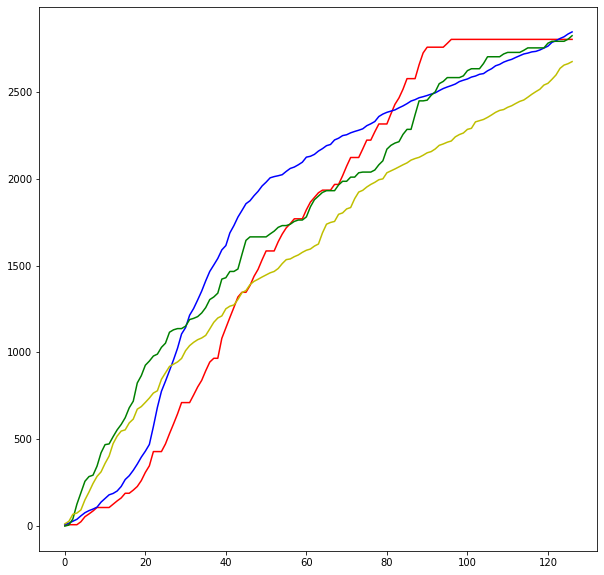

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
actual = [4, 8, 8, 8, 25, 54, 70, 87, 107, 107, 107, 107, 126, 145, 162, 189, 189, 207, 228, 262, 309, 347, 429, 429, 429, 473, 532, 588, 646, 711, 711, 711, 755, 801, 839, 894, 944, 966, 966, 1081, 1141, 1201, 1259, 1319, 1346, 1346, 1385, 1438, 1478, 1533, 1584, 1584, 1584, 1637, 1681, 1717, 1741, 1769, 1769, 1769, 1821, 1865, 1892, 1919, 1934, 1934, 1934, 1967, 1967, 2017, 2072, 2122, 2122, 2122, 2171, 2222, 2222, 2270, 2315, 2315, 2315, 2373, 2428, 2465, 2515, 2576, 2576, 2576, 2656, 2724, 2757, 2757, 2757, 2757, 2757, 2779, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802]

model1 = [8, 17, 28, 39, 59, 77, 89, 98, 109, 138, 159, 180, 188, 202, 228, 268, 290, 321, 357, 397, 431, 470, 573, 684, 776, 834, 895, 957, 1024, 1106, 1143, 1214, 1253, 1302, 1353, 1412, 1466, 1503, 1541, 1590, 1615, 1688, 1730, 1779, 1817, 1856, 1873, 1902, 1927, 1958, 1980, 2005, 2012, 2017, 2023, 2042, 2059, 2067, 2080, 2095, 2124, 2129, 2140, 2159, 2173, 2190, 2197, 2223, 2233, 2248, 2253, 2264, 2272, 2279, 2287, 2305, 2316, 2329, 2358, 2372, 2382, 2389, 2396, 2408, 2419, 2432, 2447, 2455, 2466, 2472, 2479, 2487, 2494, 2507, 2519, 2528, 2536, 2545, 2559, 2567, 2574, 2585, 2591, 2601, 2605, 2621, 2633, 2650, 2658, 2671, 2680, 2687, 2698, 2708, 2718, 2723, 2730, 2733, 2741, 2752, 2763, 2785, 2794, 2807, 2817, 2833, 2845]

model2 = [0, 6, 41, 126, 192, 258, 285, 293, 345, 422, 469, 473, 515, 554, 585, 624, 681, 719, 824, 866, 926, 950, 979, 990, 1029, 1053, 1116, 1130, 1137, 1137, 1151, 1189, 1196, 1206, 1227, 1258, 1304, 1319, 1341, 1422, 1430, 1466, 1466, 1480, 1564, 1645, 1665, 1665, 1665, 1665, 1665, 1682, 1698, 1720, 1730, 1730, 1738, 1754, 1762, 1762, 1780, 1838, 1879, 1900, 1921, 1931, 1931, 1931, 1964, 1985, 1985, 2009, 2009, 2034, 2038, 2038, 2038, 2050, 2080, 2103, 2170, 2192, 2205, 2213, 2255, 2284, 2284, 2368, 2448, 2448, 2452, 2480, 2500, 2547, 2560, 2582, 2582, 2582, 2582, 2592, 2622, 2633, 2633, 2633, 2663, 2702, 2702, 2702, 2702, 2718, 2727, 2727, 2727, 2727, 2739, 2753, 2753, 2753, 2753, 2753, 2780, 2791, 2791, 2791, 2791, 2803, 2823]
model3 = [13, 27, 68, 75, 93, 151, 196, 245, 286, 312, 361, 403, 475, 518, 547, 554, 594, 616, 673, 688, 712, 737, 766, 779, 845, 882, 919, 932, 945, 965, 1010, 1039, 1058, 1073, 1083, 1098, 1135, 1173, 1198, 1210, 1251, 1266, 1273, 1305, 1344, 1356, 1390, 1409, 1421, 1434, 1446, 1458, 1466, 1483, 1511, 1534, 1538, 1551, 1561, 1576, 1588, 1595, 1612, 1624, 1688, 1738, 1748, 1754, 1795, 1803, 1826, 1834, 1885, 1923, 1933, 1952, 1967, 1979, 1994, 1999, 2034, 2045, 2056, 2068, 2080, 2091, 2107, 2116, 2123, 2135, 2149, 2156, 2171, 2192, 2200, 2210, 2217, 2241, 2254, 2263, 2284, 2290, 2327, 2334, 2341, 2353, 2367, 2382, 2393, 2398, 2411, 2420, 2433, 2445, 2453, 2469, 2486, 2501, 2515, 2539, 2549, 2572, 2597, 2635, 2654, 2662, 2674]
plt.plot(actual, 'r-', model1, 'b-', model2, 'g-', model3, 'y-')
plt.show()